In [266]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np
import random

In [267]:
# load breast cancer
data = load_breast_cancer()
indices = np.random.permutation(len(data.target))
data.data, data.target = data.data[indices], data.target[indices]

In [268]:
class Dataset:
    def __init__(self, data):
      self.x, self.y = data
    def __getitem__(self, item): return self.x[item], self.y[item]
    def __len__(self): return len(self.y)
# Dataset

trainset = Dataset((data.data[:100, 0:2], data.target[:100]))
testset = Dataset((data.data[100:, 0:2], data.target[100:]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


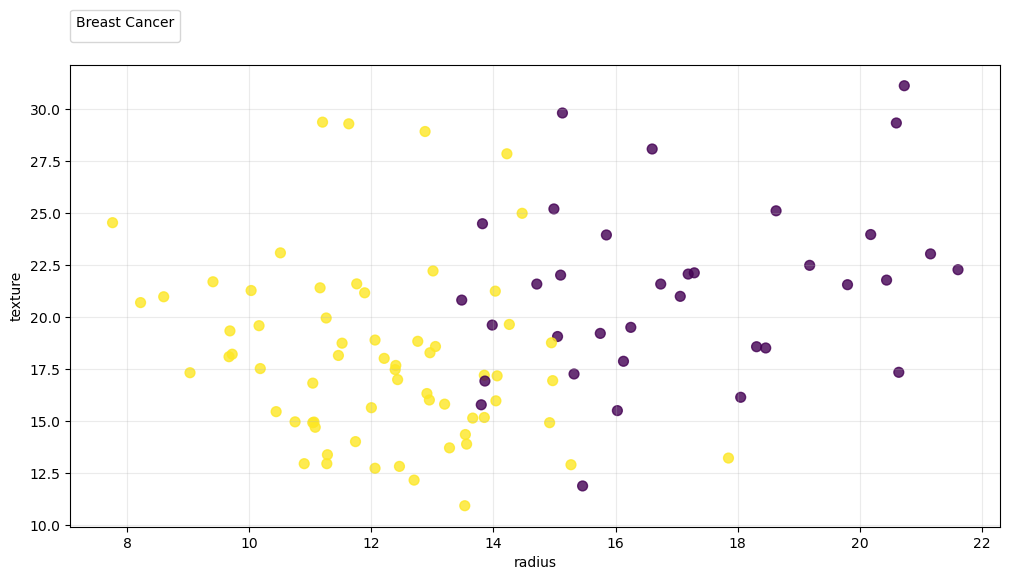

In [269]:
# plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.set_xlabel('radius')
ax1.set_ylabel('texture')
ax1.grid(True, alpha=0.25)
ax1.scatter(x=trainset.x[:, 0], y=trainset.x[:, 1], s=50, alpha=0.8, c=trainset.y)
ax1.legend(title="Breast Cancer", fontsize=10, loc=(0,1.05))

In [270]:
def sigmoid(x, e=2.7182): return 1 / (1 + e ** (-x))
def reLu(x): return np.array(max(0, x))

In [271]:
def gdr(x, y, weight, act_func, lr):
    indications = act_func(np.dot(x, weight))
    weight -= (lr / x.shape[0]) * np.dot(x.T, (indications - y))
# gdr

class LogisticRegression:
    def __init__(self, n_inpt): self.weight = np.random.rand(n_inpt)
    def train(self, dataset, iters: int, lr=0.01):
        for _ in range(iters):
            for x, y in dataset:
                gdr(x, y, self.weight, act_func=reLu, lr=lr)
    # train
    
    def __call__(self, x): return 1 if np.dot(x, self.weight) >= 0.5 else 0
    
    def loss(self, xy):
        x, y = xy.data[:100, 0:2], xy.target[:100]
        probability = np.dot(x, self.weight)
        loss = np.mean(np.exp(1 - probability) * y) + np.sum(np.exp(probability) * (1 - y))
        print(f"cost: {loss:.3f}")
    # loss
# LogisticRegression

In [272]:
model = LogisticRegression(len(trainset.x[0]))
model.loss(data)
model.train(trainset, iters=1000, lr=0.001)

cost: 212091213911025.531


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


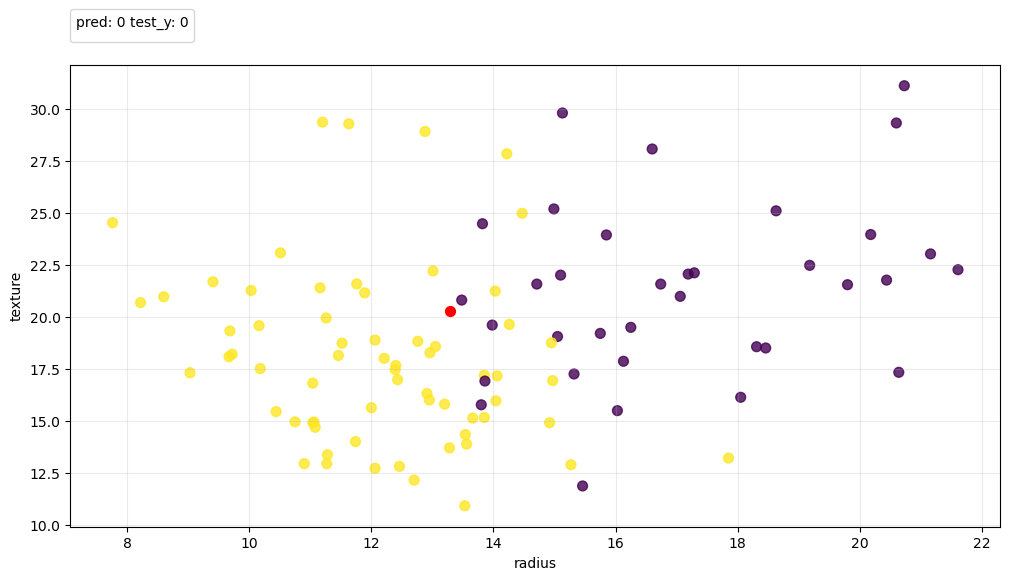

In [273]:
index = random.randrange(0, 100)
test_x, test_y = testset[index]
pred = model(test_x)
ax1.scatter(x=test_x[0], y=test_x[1], s=50, alpha=1, c="r")
ax1.legend(title=f"pred: {pred} test_y: {test_y}", fontsize=10, loc=(0,1.05))
fig

In [274]:
model.loss(data)

cost: 49.783
